In [1]:
from __future__ import division, print_function
import numpy as np

from numpy import cov
import random

from scipy.stats import gaussian_kde


import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits import mplot3d
import os
import pandas as pd
import scipy.stats
import scipy.stats as stats
from scipy.stats import norm
import requests, io # for HTTP requests and I/O commands
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt # for data visualization
%matplotlib inline

# scikit-learn modules
from sklearn.model_selection import train_test_split # for splitting the data
from sklearn.metrics import mean_squared_error # for calculating the cost function
from sklearn.ensemble import RandomForestRegressor # for building the model



1.4939666232630797


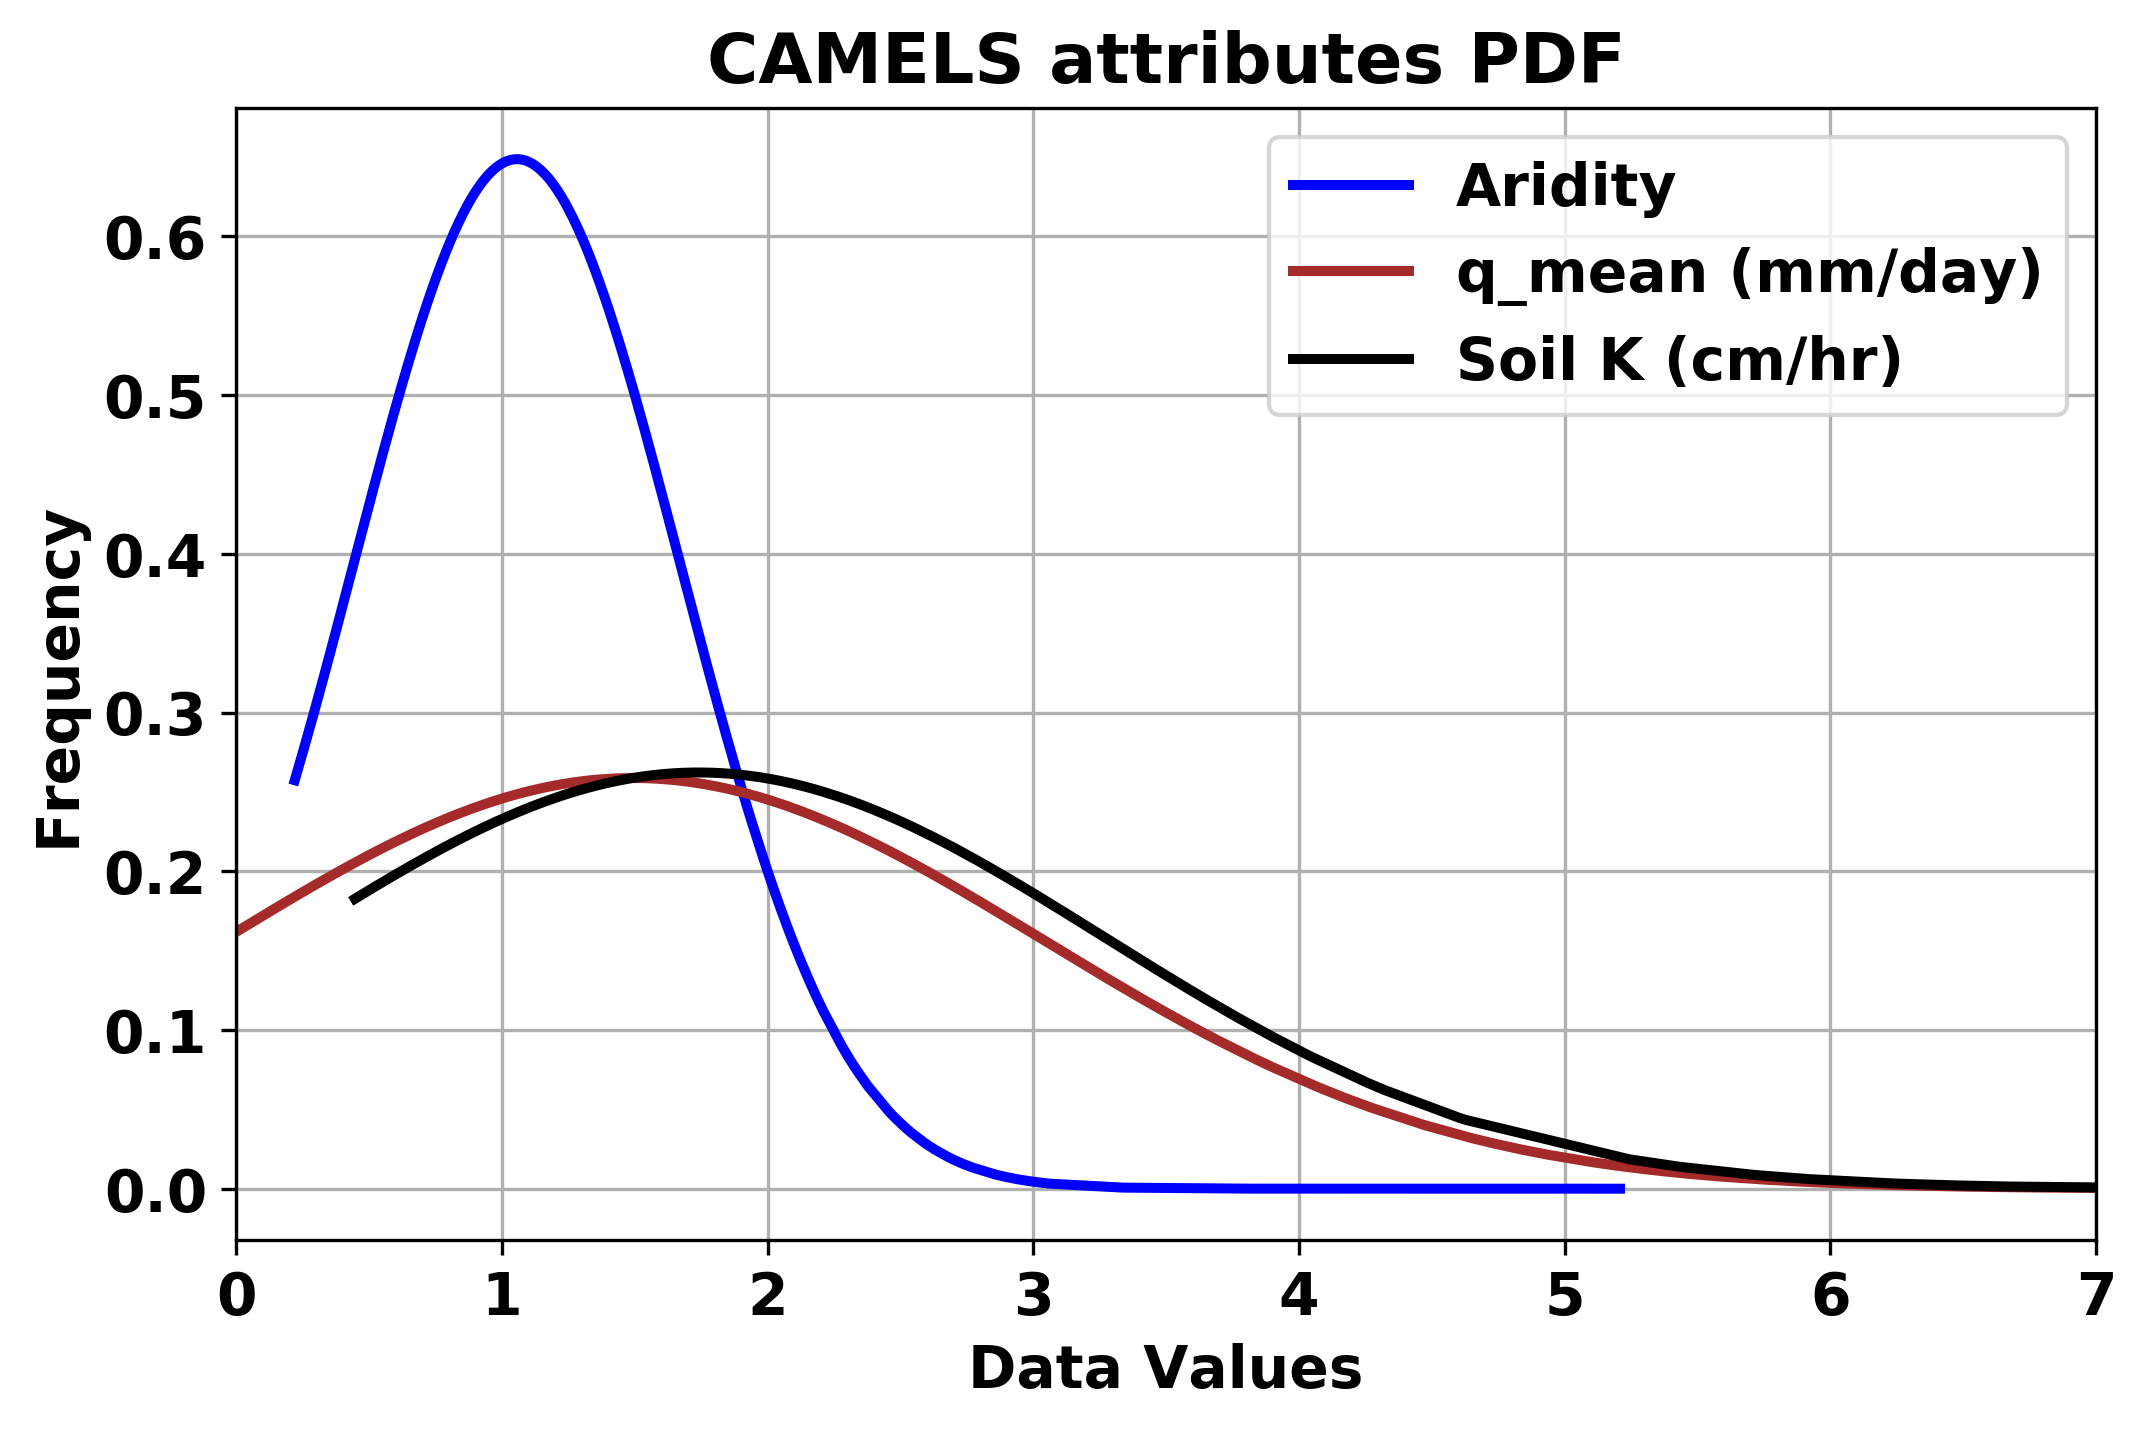

In [3]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 14}

matplotlib.rc('font', **font)

# read text file into pandas DataFrame
df1 = pd.read_csv("/Users/mochiliao/Documents/Research/2022SI/camels_attributes_v2.0/camels_clim.txt", sep=";")
# print(df)
tmp = df1.iloc[:,5]# This is aridity
aridity = tmp.values

df2 = pd.read_csv("/Users/mochiliao/Documents/Research/2022SI/camels_attributes_v2.0/camels_hydro.txt", sep=";")
#print(df)
tmp = df2.iloc[:,1]# This is q_mean
q_mean = tmp.values

df3 = pd.read_csv("/Users/mochiliao/Documents/Research/2022SI/camels_attributes_v2.0/camels_soil.txt", sep=";")
tmp = df3.iloc[:,4]# This is soil conductivity
conductivity = tmp.values


fig = plt.figure(figsize = (8, 5), dpi = 300)

aridity.sort()# to plot PDF
df_mean = np.mean(aridity)
df_std = np.std(aridity)
pdf = stats.norm.pdf(aridity, df_mean, df_std)
plt.plot(aridity, pdf, color = "blue", lw=2.4, label='Aridity')

q_mean.sort()
df_mean = np.nanmean(q_mean)
df_std = np.nanstd(q_mean)
pdf = stats.norm.pdf(q_mean, df_mean, df_std)
print(df_mean)
plt.plot(q_mean, pdf, color = "Brown", lw=2.4, label='q_mean (mm/day)')

conductivity.sort()
df_mean = np.mean(conductivity)
df_std = np.std(conductivity)
pdf = stats.norm.pdf(conductivity, df_mean, df_std)
plt.plot(conductivity, pdf, color = "k", lw=2.4, label='Soil K (cm/hr)')


#plt.hist(conductivity, normed=1, color = "k", ec="k", lw=0.4, alpha = 0.5, label='Soil conductivity')
#plt.hist(q_mean, normed=1, color = "Brown", ec="Brown", lw=0.4, alpha = 0.5, label='q_mean')
#plt.hist(aridity, normed=1, color = "lightblue", ec="blue", lw=0.4, alpha = 0.5, label='Aridity')
plt.xlim([0, 7])
plt.xlabel('Data Values',fontweight='bold')
plt.ylabel('Frequency',fontweight='bold')
plt.title("CAMELS attributes PDF",fontweight='bold')
plt.grid()
plt.legend()


# Now, let's use 17 inputs to predict KGE from LSTM and SAC using Daily resolution

In [3]:
forcing = ['nldas','daymet']
split = ['split1','split2']
metrix = ['KGE','NSE','Alpha-NSE','Beta-NSE']

In [4]:
from pathlib import Path

#lst = [[0,0,0]]
#dfall = pd.DataFrame(lst, columns =['Method', 'LSTM-corr', 'SAC-corr']) 
dfall = pd.DataFrame()
pathlist = Path("/Users/mochiliao/Documents/Research/2022SI/data_for_model_selection").glob('**/*.csv')

for path in pathlist:
    dft = pd.read_csv(path)
    # This is the target data sets
    #dft = pd.read_csv("/Users/mochiliao/Documents/Research/2022SI/data_for_model_selection/nldas_time_split2_NSE.csv")
    dft.columns = ['GaugeID','LSTM','MC','SAC']
    Y = dft[["LSTM","SAC"]]
    g_id = dft[["GaugeID"]]

    # This is the input data sets
    df1 = pd.read_csv("/Users/mochiliao/Documents/Research/2022SI/camels_attributes_v2.0/camels_clim.txt", sep=";")
    df2 = pd.read_csv("/Users/mochiliao/Documents/Research/2022SI/camels_attributes_v2.0/camels_soil.txt", sep=";")
    df3 = pd.read_csv("/Users/mochiliao/Documents/Research/2022SI/camels_attributes_v2.0/camels_topo.txt", sep=";")
    df4 = pd.read_csv("/Users/mochiliao/Documents/Research/2022SI/camels_attributes_v2.0/camels_geol.txt", sep=";")

    df2.head()
    df1_s = df1[["gauge_id","p_mean","pet_mean","aridity","frac_snow","high_prec_freq","high_prec_dur","low_prec_freq","low_prec_dur"]]
    df2_s = df2[["gauge_id","clay_frac","silt_frac","sand_frac","soil_depth_pelletier","organic_frac"]]
    df3_s = df3[["gauge_id","area_gages2","slope_mean","elev_mean"]]
    df4_s = df4[["gauge_id","geol_permeability"]]


    tmp = pd.merge(df1_s,df2_s,left_on='gauge_id', right_on='gauge_id', how='left')
    tmp1 = pd.merge(tmp,df3_s,left_on='gauge_id', right_on='gauge_id', how='left')
    tmp2 = pd.merge(tmp1,df4_s,left_on='gauge_id', right_on='gauge_id', how='left')
    tmpx = tmp2.drop(['high_prec_freq','high_prec_dur','low_prec_freq','low_prec_dur','soil_depth_pelletier','organic_frac','geol_permeability'], axis=1)

    x = pd.merge(g_id,tmpx,left_on='GaugeID', right_on='gauge_id', how='left').drop('gauge_id', axis=1)
    X = x.drop('GaugeID', axis=1)

    # ==========
    # ========== split datasets and train the regressor
    # ==========
    LSTM_test_all = []
    LSTM_pred_all = []
    SAC_test_all = []
    SAC_pred_all = []

    for i in range(0, 10):
        j = random.randint(0, 100)
        # Splitting the dataset into training and testing set (80/20)
        x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = j)

        # Initializing the Random Forest Regression model with 10 decision trees
        model = RandomForestRegressor(n_estimators = 12, random_state = j)

        # Fitting the Random Forest Regression model to the data
        model.fit(x_train, y_train)

        # Predicting the target values of the test set
        y_pred = model.predict(x_test)

        # RMSE (Root Mean Square Error)
        rmse = float(format(np.sqrt(mean_squared_error(y_test, y_pred)), '.3f'))
        #print("\nRMSE: ", rmse)
        #print("Randome state is ", j)

        tmp = y_test.iloc[:,0]# this is LSTM
        LSTM_test = tmp.values
        tmp = y_test.iloc[:,1]# this is SAC
        SAC_test = tmp.values

        LSTM_pred = y_pred[:,0]
        SAC_pred = y_pred[:,1]

        LSTM_test_all = np.concatenate( (LSTM_test_all, LSTM_test ) )
        LSTM_pred_all = np.concatenate( (LSTM_pred_all, LSTM_pred ) )
        SAC_test_all = np.concatenate( (SAC_test_all, SAC_test ) )
        SAC_pred_all = np.concatenate( (SAC_pred_all, SAC_pred ) )


        # START plotting results %%%%%%%%%%%%%%%   Calculate the point density
    xy = np.vstack([LSTM_test_all,LSTM_pred_all])
    z = gaussian_kde(xy)(xy)
    
#     fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=100)
#     ax.scatter(LSTM_test_all, LSTM_pred_all, c=z, s=10)
#     plt.plot([-1,1], [-1,1]);
#     #ax.set_xlim(-1, 1)
#     plt.xticks(np.arange(-1, 1, step=0.25))
#     plt.yticks(np.arange(-1, 1, step=0.25))
#     plt.xlabel('LSTM test')
#     plt.ylabel('LSTM pred')
#     plt.title('LSTM KGE values')
#     plt.xlim(-0.75, 1)
#     plt.ylim(-0.75, 1)
#     plt.grid()
    #plt.show()
    
    LSTM_corr = np.corrcoef(LSTM_pred_all, LSTM_test_all)[0][1]
    #print("\nLSTM corr: ", LSTM_corr)

    xy = np.vstack([SAC_test_all,SAC_pred_all])
    z = gaussian_kde(xy)(xy)
    
#     fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=100)
#     ax.scatter(SAC_test_all, SAC_pred_all, c=z, s=10)
#     plt.plot([-1,1], [-1,1]);
#     plt.xticks(np.arange(-1, 1, step=0.25))
#     plt.yticks(np.arange(-1, 1, step=0.25))
#     plt.xlabel('SAC test')
#     plt.ylabel('SAC pred')
#     plt.title('SAC KGE values')
#     plt.xlim(-0.75, 1)
#     plt.ylim(-0.75, 1)
#     plt.grid()
    #plt.show()
    
    SAC_corr = np.corrcoef(SAC_pred_all, SAC_test_all)[0][1]
    #print("\nSAC corr: ", SAC_corr)
    lst = [[path.name[0:-4],LSTM_corr,SAC_corr]]
    dftmp = pd.DataFrame(lst, columns =['Method', 'LSTM-corr', 'SAC-corr']) 
    dfall = pd.concat([dfall,dftmp], axis=0)
    

In [5]:
dfall

,Method,LSTM-corr,SAC-corr
0,nldas_time_split2_FMS,-0.005295,-0.005296
0,nldas_time_split2_Beta-NSE,0.407953,0.432945
0,daymet_time_split2_Beta-NSE,0.408964,0.448234
0,nldas_time_split2_FLV,0.087730,0.219349
0,daymet_time_split1_Pearson-r,0.334242,0.348850
0,daymet_time_split1_FHV,0.020421,0.084306
0,nldas_time_split2_Pearson-r,0.433481,0.435034
0,nldas_time_split1_Pearson-r,0.473387,0.481305
0,daymet_time_split2_MSE,0.299253,0.303989
0,daymet_time_split2_KGE,0.404175,0.425339


# Now, let's use 10 inputs to predict NSE from LSTM and CFE using Hourly resolution

In [17]:
from pathlib import Path

# ========= Read Catchment attributes below
df1 = pd.read_csv("/Users/mochiliao/Documents/Research/2022SI/camels_attributes_v2.0/camels_clim.txt", sep=";")
df2 = pd.read_csv("/Users/mochiliao/Documents/Research/2022SI/camels_attributes_v2.0/camels_soil.txt", sep=";")
df3 = pd.read_csv("/Users/mochiliao/Documents/Research/2022SI/camels_attributes_v2.0/camels_topo.txt", sep=";")
df4 = pd.read_csv("/Users/mochiliao/Documents/Research/2022SI/camels_attributes_v2.0/camels_geol.txt", sep=";")


df1_s = df1[["gauge_id","p_mean","pet_mean","aridity","frac_snow","high_prec_freq","high_prec_dur","low_prec_freq","low_prec_dur"]]
df2_s = df2[["gauge_id","clay_frac","silt_frac","sand_frac","soil_depth_pelletier","organic_frac"]]
df3_s = df3[["gauge_id","area_gages2","slope_mean","elev_mean"]]
df4_s = df4[["gauge_id","geol_permeability"]]


tmp = pd.merge(df1_s,df2_s,left_on='gauge_id', right_on='gauge_id', how='left')
tmp1 = pd.merge(tmp,df3_s,left_on='gauge_id', right_on='gauge_id', how='left')
tmp2 = pd.merge(tmp1,df4_s,left_on='gauge_id', right_on='gauge_id', how='left')
tmpx = tmp2.drop(['high_prec_freq','high_prec_dur','low_prec_freq','low_prec_dur','soil_depth_pelletier','organic_frac','geol_permeability'], axis=1)

# ======== Read CFE results below

dftmp = pd.read_csv("/Users/mochiliao/Documents/Research/2022SI/real_outputs/models_performance.csv", sep=",")
NSE_H = dftmp[['basin_id','cfe_nse']]

# ======== Read LSTM results below 

pathlist = Path("/Users/mochiliao/Documents/Research/2022SI/real_outputs/LSTM Performance Metrics").glob('**/*.csv')
L_ID = []
LSTM_H = []
for path in pathlist:
    dft = pd.read_csv(path)
    tmp11 = dft["basin"].values
    tmp22 = dft["NSE"].values
    L_ID = np.concatenate( (L_ID, tmp11 ))
    LSTM_H = np.concatenate( (LSTM_H, tmp22) )

Y1 = pd.DataFrame(L_ID, columns=['G_ID'])
Y2 = pd.DataFrame(LSTM_H, columns=['LSTM-H-NSE'])
YH = pd.concat([Y1,Y2], axis=1)

# ======== results summary ====

sum_results_tmp = pd.merge(NSE_H,YH,left_on='basin_id', right_on='G_ID', how='left').drop('G_ID',axis=1)
sum_results = pd.merge(tmpx,sum_results_tmp,left_on='gauge_id',right_on='basin_id', how='left').drop('basin_id',axis=1).dropna(axis=0)

# ===== rename columns =====

sum_results.rename(columns = {'cfe_nse':'CFE-H-NSE'}, inplace = True)



In [18]:
X_H.head()

,p_mean,pet_mean,aridity,frac_snow,clay_frac,silt_frac,sand_frac,area_gages2,slope_mean
1,3.608126,2.119256,0.587356,0.245259,12.037646,28.080937,59.390156,573.60,17.79072
3,3.522957,2.071324,0.587950,0.291836,12.654125,50.841232,35.269030,769.05,29.56035
4,3.323146,2.090024,0.628929,0.280118,10.303622,34.185443,55.163133,909.10,49.92122
5,3.730858,2.096423,0.561914,0.352698,11.143326,52.614646,30.557666,383.82,60.05183
6,4.067132,2.128355,0.523306,0.299642,9.851262,31.836472,58.376169,180.98,90.13951


In [19]:
Y_H.head()

,CFE-H-NSE,LSTM-H-NSE
1,0.575643,0.743211
3,0.478464,0.845839
4,0.432895,0.800601
5,0.021447,0.696136
6,0.122888,0.609227


In [133]:
# ===== this is to get X and Y as inputs to the random regressor
X_H = sum_results.drop(['gauge_id','CFE-H-NSE','LSTM-H-NSE'],axis=1)
Y_H = sum_results[['CFE-H-NSE','LSTM-H-NSE']]


LSTM_test_all = []
LSTM_pred_all = []
CFE_test_all = []
CFE_pred_all = []
model_select = 'LSTM'
# a choice of Both, LSTM, CFE

if model_select == 'Both':
    for i in range(0, 10):

        j = random.randint(0, 100)

        # Splitting the dataset into training and testing set (80/20)
        x_train, x_test, y_train, y_test = train_test_split(X_H, Y_H, test_size = 0.2, random_state = j)

        # Initializing the Random Forest Regression model with 10 decision trees
        model = RandomForestRegressor(n_estimators = 12, random_state = j)

        # Fitting the Random Forest Regression model to the data
        model.fit(x_train, y_train)

        # Predicting the target values of the test set
        y_pred = model.predict(x_test)
        y_pred_train = model.predict(x_train)

        # RMSE (Root Mean Square Error)
        rmse_test = float(format(np.sqrt(mean_squared_error(y_test, y_pred)), '.3f'))
        rmse_train = float(format(np.sqrt(mean_squared_error(y_train, y_pred_train)), '.3f'))
        print("\nRMSE: testing", rmse_test)
        print("RMSE: training", rmse_train)
        print("Randome state is ", j)

        tmp = y_test.iloc[:,1]# this is LSTM
        LSTM_test = tmp.values
        tmp = y_test.iloc[:,0]# this is CFE
        CFE_test = tmp.values

        LSTM_pred = y_pred[:,1]
        CFE_pred = y_pred[:,0]

        LSTM_test_all = np.concatenate( (LSTM_test_all, LSTM_test ) )
        LSTM_pred_all = np.concatenate( (LSTM_pred_all, LSTM_pred ) )

        CFE_test_all = np.concatenate( (CFE_test_all, CFE_test ) )
        CFE_pred_all = np.concatenate( (CFE_pred_all, CFE_pred ) )

        LSTM_test_all = 1/(2-LSTM_test_all)
        LSTM_pred_all = 1/(2-LSTM_pred_all)
        CFE_test_all = 1/(2-CFE_test_all)
        CFE_pred_all = 1/(2-CFE_pred_all)
        
elif model_select == 'LSTM':
    for i in range(0, 10):

        j = random.randint(0, 100)
        Y_H = Y_H[['LSTM-H-NSE']]

        # Splitting the dataset into training and testing set (80/20)
        x_train, x_test, y_train, y_test = train_test_split(X_H, Y_H, test_size = 0.1, random_state = j)

        # Initializing the Random Forest Regression model with 10 decision trees
        model = RandomForestRegressor(n_estimators = 12, random_state = j)

        # Fitting the Random Forest Regression model to the data
        model.fit(x_train, y_train)

        # Predicting the target values of the test set
        y_pred = model.predict(x_test)
        y_pred_train = model.predict(x_train)

        # RMSE (Root Mean Square Error)
        rmse_test = float(format(np.sqrt(mean_squared_error(y_test, y_pred)), '.3f'))
        rmse_train = float(format(np.sqrt(mean_squared_error(y_train, y_pred_train)), '.3f'))
        print("\nRMSE: testing", rmse_test)
        print("RMSE: training", rmse_train)
        print("Randome state is ", j)

        tmp = y_test.iloc[:,0]# this is CFE
        LSTM_test = tmp.values
        LSTM_pred = y_pred

        LSTM_test_all = np.concatenate( (LSTM_test_all, LSTM_test ) )
        LSTM_pred_all = np.concatenate( (LSTM_pred_all, LSTM_pred ) )

        LSTM_test_all = 1/(2-LSTM_test_all)
        LSTM_pred_all = 1/(2-LSTM_pred_all)

elif model_select == 'CFE':
    for i in range(0, 10):

        j = random.randint(0, 100)
        Y_H = Y_H[['CFE-H-NSE']]

        # Splitting the dataset into training and testing set (80/20)
        x_train, x_test, y_train, y_test = train_test_split(X_H, Y_H, test_size = 0.2, random_state = j)

        # Initializing the Random Forest Regression model with 10 decision trees
        model = RandomForestRegressor(n_estimators = 14, random_state = j)

        # Fitting the Random Forest Regression model to the data
        model.fit(x_train, y_train)

        # Predicting the target values of the test set
        y_pred = model.predict(x_test)
        y_pred_train = model.predict(x_train)

        # RMSE (Root Mean Square Error)
        rmse_test = float(format(np.sqrt(mean_squared_error(y_test, y_pred)), '.3f'))
        rmse_train = float(format(np.sqrt(mean_squared_error(y_train, y_pred_train)), '.3f'))
        print("\nRMSE: testing", rmse_test)
        print("RMSE: training", rmse_train)
        print("Randome state is ", j)

        tmp = y_test.iloc[:,0]# this is CFE
        CFE_test = tmp.values

        CFE_pred = y_pred

        CFE_test_all = np.concatenate( (CFE_test_all, CFE_test ) )
        CFE_pred_all = np.concatenate( (CFE_pred_all, CFE_pred ) )

        CFE_test_all = 1/(2-CFE_test_all)
        CFE_pred_all = 1/(2-CFE_pred_all)
    

/Users/mochiliao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/Users/mochiliao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/Users/mochiliao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/Users/mochiliao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



RMSE: testing 2.936
RMSE: training 4.477
Randome state is  85

RMSE: testing 14.226
RMSE: training 3.708
Randome state is  99

RMSE: testing 15.491
RMSE: training 2.882
Randome state is  84

RMSE: testing 4.506
RMSE: training 4.441
Randome state is  28

RMSE: testing 2.693
RMSE: training 4.524
Randome state is  7

RMSE: testing 3.18
RMSE: training 4.399
Randome state is  5

RMSE: testing 4.245
RMSE: training 3.765
Randome state is  77


/Users/mochiliao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/Users/mochiliao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/Users/mochiliao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/Users/mochiliao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/Users/mochiliao/anaconda3/lib/python3.7/site-packages/i


RMSE: testing 5.88
RMSE: training 3.562
Randome state is  82

RMSE: testing 16.817
RMSE: training 2.975
Randome state is  40

RMSE: testing 8.051
RMSE: training 3.777
Randome state is  15


/Users/mochiliao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



LSTM corr:  0.8173272392177492


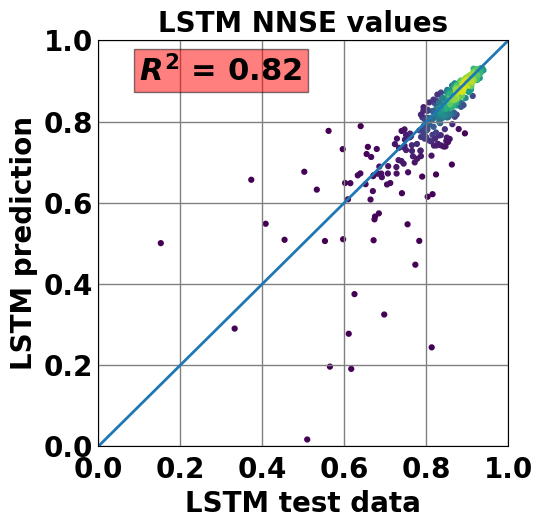

In [134]:
plt.rcParams.update({
        "font.weight": "bold",
        "xtick.major.size": 0.2,
        "ytick.major.size": 0.2,
        "xtick.major.pad": 7,
        "xtick.labelsize": 20,
        "ytick.labelsize": 20,
        "grid.color": "0.5",
        "grid.linestyle": "-",
        "grid.linewidth": 1,
        "lines.linewidth": 2,
        "lines.color": "g",
    })

if model_select=='LSTM' or model_select=='Both':
    # Calculate the point density
    xy = np.vstack([LSTM_test_all,LSTM_pred_all])
    z = gaussian_kde(xy)(xy)
    fig, ax = plt.subplots(1, 1, figsize=(5.65, 5.5), dpi=100) 
    ax.scatter(LSTM_test_all, LSTM_pred_all, c=z, s=12)
    plt.plot([-10,1], [-10,1]);
    plt.xticks(np.arange(-10, 10, step=0.2))
    plt.yticks(np.arange(-10, 10, step=0.2))
    plt.xlabel('LSTM test data',fontweight='bold',fontsize=20)
    plt.ylabel('LSTM prediction',fontweight='bold',fontsize=20)
    plt.title("LSTM NNSE values",fontweight='bold',fontsize=20)
    LSTM_corr = np.corrcoef(LSTM_pred_all, LSTM_test_all)[0][1]
    plt.text(0.1, 0.9, '$R^2$ = '+ "{:.2f}".format(LSTM_corr), fontsize = 22, 
             bbox = dict(facecolor = 'red', alpha = 0.5))
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.grid()
    #plt.show()
    plt.tight_layout()
    plt.savefig('LSTM-correlation 17.png')
    print("\nLSTM corr: ", LSTM_corr) 

if model_select=='CFE' or model_select=='Both':
    xy = np.vstack([CFE_test_all,CFE_pred_all])
    z = gaussian_kde(xy)(xy)
    fig, ax = plt.subplots(1, 1, figsize=(5.65, 5.5), dpi=100)
    ax.scatter(CFE_test_all, CFE_pred_all, c=z, s=12)
    plt.plot([-10,1], [-10,1]);
    plt.xticks(np.arange(-10, 10, step=0.2))
    plt.yticks(np.arange(-10, 10, step=0.2))
    plt.xlabel('CFE test data',fontweight='bold',fontsize=20)
    plt.ylabel('CFE prediction',fontweight='bold',fontsize=20)
    plt.title("CFE NNSE values",fontweight='bold',fontsize=20)
    CFE_corr = np.corrcoef(CFE_pred_all, CFE_test_all)[0][1]
    plt.text(0.1, 0.9, '$R^2$ = ' + "{:.2f}".format(CFE_corr) , fontsize = 22, 
             bbox = dict(facecolor = 'red', alpha = 0.5))
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.grid()
    #plt.show()
    plt.tight_layout()
    plt.savefig('CFE-correlation 17.png')

    print("\nCFE corr: ", CFE_corr)

SyntaxError: invalid syntax (<ipython-input-151-bc80975050b9>, line 1)

In [152]:
import pickle

run_dir = Path("/Users/mochiliao/Documents/Research/2022SI/project_outputs/runs/fold_1_0807_012125/")
with open(run_dir / "test" / "model_epoch003" / "test_results.p", "rb") as fp:
    results = pickle.load(fp)
    
results.keys()  
#len(list(results.keys()))
# extract observations and simulations
#qobs = results['14306500']['1H']['xr']['QObs_CAMELS(mm/h)_obs']
#qsim = results['14306500']['1H']['xr']['QObs_CAMELS(mm/h)_sim']

ValueError: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216 from C header, got 192 from PyObject